# **Klasifikasi Jenis Sayur**

---



### **Import Library**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os
import time
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from skimage.feature import local_binary_pattern
from joblib import Parallel, delayed

In [2]:
# set style untuk plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### **Load Dataset**

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'vegetable-image-dataset' dataset.
Path to dataset files: /kaggle/input/vegetable-image-dataset


In [4]:
train_dir = r"/kaggle/input/vegetable-image-dataset/Vegetable Images/train"

class_names = os.listdir(train_dir)
print("Class names:", class_names)
print("Number of classes:", len(class_names))

Class names: ['Broccoli', 'Capsicum', 'Bottle_Gourd', 'Radish', 'Tomato', 'Brinjal', 'Pumpkin', 'Carrot', 'Papaya', 'Cabbage', 'Bitter_Gourd', 'Cauliflower', 'Bean', 'Cucumber', 'Potato']
Number of classes: 15


In [5]:
train_counts = []

for class_name in class_names:
    path = os.path.join(train_dir, class_name)
    train_counts.append(len(os.listdir(path)))

df_counts = pd.DataFrame({
    'Nama Kelas/Sayur': class_names,
    'Jumlah Gambar': train_counts
}).sort_values(by='Jumlah Gambar', ascending=False).reset_index(drop=True)

print(df_counts)

   Nama Kelas/Sayur  Jumlah Gambar
0          Broccoli           1000
1          Capsicum           1000
2      Bottle_Gourd           1000
3            Radish           1000
4            Tomato           1000
5           Brinjal           1000
6           Pumpkin           1000
7            Carrot           1000
8            Papaya           1000
9           Cabbage           1000
10     Bitter_Gourd           1000
11      Cauliflower           1000
12             Bean           1000
13         Cucumber           1000
14           Potato           1000


### **Pra Pengolahan Data**

In [6]:
def preprocess_image(img_path, img_size=(128, 128)):
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # crop tengah
    h, w = img.shape[:2]
    min_dim = min(h, w)
    start_x = w//2 - min_dim//2
    start_y = h//2 - min_dim//2
    img_cropped = img[start_y:start_y+min_dim, start_x:start_x+min_dim]

    # resize ke ukuran konsisten
    img_resized = cv.resize(img_cropped, img_size)

    # rotasi untuk augmentasi
    angle = np.random.uniform(-15, 15)
    M = cv.getRotationMatrix2D((img_size[0]//2, img_size[1]//2), angle, 1)
    img_rotated = cv.warpAffine(img_resized, M, img_size)

    # IMAGE ENHANCEMENT
    # contrast dan brightness correction
    img_enhanced = cv.convertScaleAbs(img_rotated, alpha=1.2, beta=10)

    # noise removal
    img_denoised = cv.GaussianBlur(img_enhanced, (3, 3), 0)

    # glare removal dengan histogram equalization
    yuv = cv.cvtColor(img_denoised, cv.COLOR_RGB2YUV)
    yuv[:,:,0] = cv.equalizeHist(yuv[:,:,0])
    img_final = cv.cvtColor(yuv, cv.COLOR_YUV2RGB)

    # normalisasi
    img_final = img_final / 255.0

    return img_final

In [7]:
images_for_display = []
labels_for_display = []

for i in range(10):
    class_name = class_names[i]
    class_path = os.path.join(train_dir, class_name)

    img_file = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, img_file)

    processed_img = preprocess_image(img_path)
    if processed_img is not None:
        images_for_display.append(processed_img)
        labels_for_display.append(i)

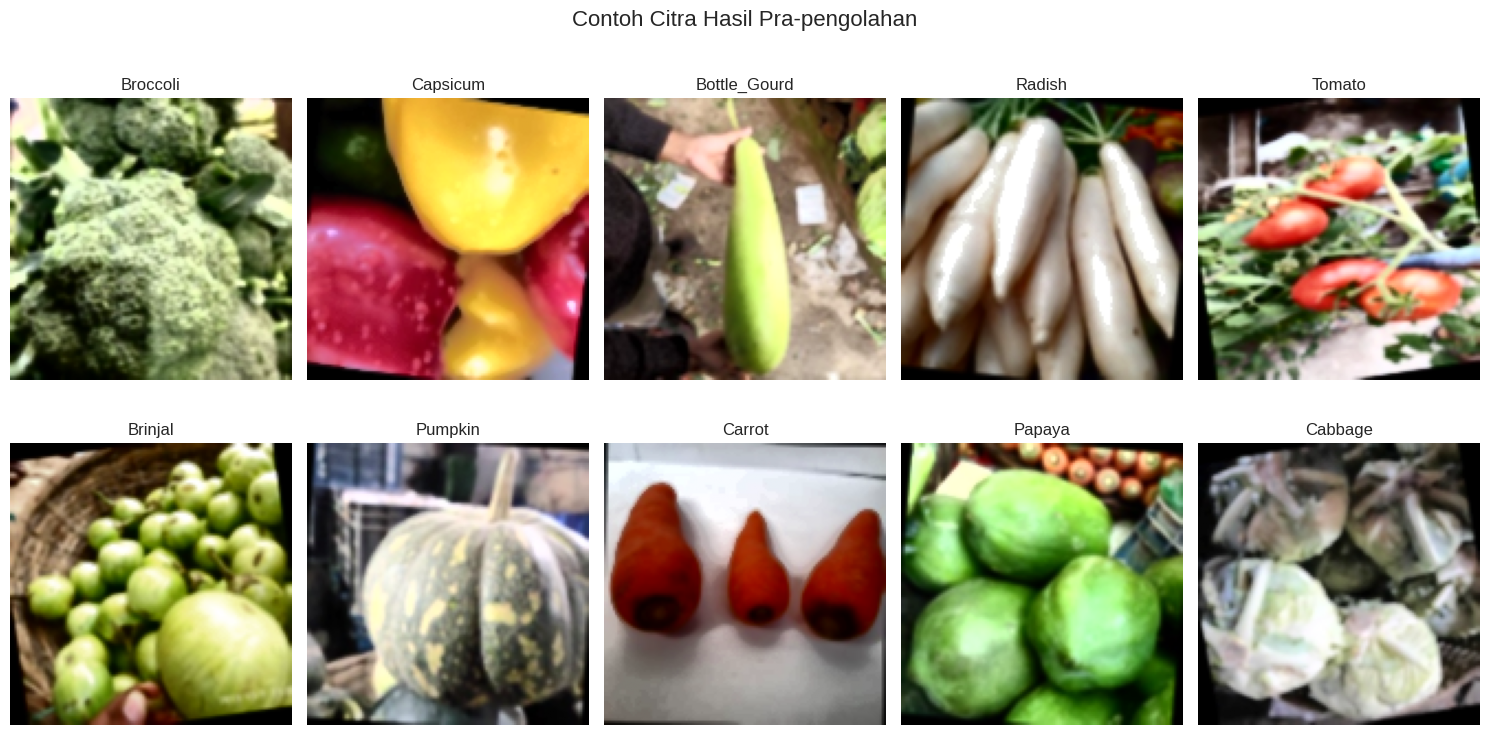

In [8]:
plt.figure(figsize=(15, 8))
for i in range(len(images_for_display)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_for_display[i])
    plt.title(f'{class_names[labels_for_display[i]]}')
    plt.axis('off')

plt.suptitle('Contoh Citra Hasil Pra-pengolahan', fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
del images_for_display
del labels_for_display

### **Ekstraksi Fitur**

In [10]:
def extract_features(images):
    color_features = []
    texture_features = []

    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)

        hsv = cv.cvtColor(img_uint8, cv.COLOR_RGB2HSV)
        h_mean, s_mean, v_mean = np.mean(hsv, axis=(0,1))
        h_std, s_std, v_std = np.std(hsv, axis=(0,1))
        color_feat = [h_mean, s_mean, v_mean, h_std, s_std, v_std]

        # fitur tekstur
        gray = cv.cvtColor(img_uint8, cv.COLOR_RGB2GRAY)

        # implementasi LBP
        P = 8
        R = 1
        lbp = local_binary_pattern(gray, P=P, R=R, method='default')

        # histogram LBP sebagai fitur tekstur
        hist, _ = np.histogram(lbp.ravel(), bins=32, range=(0, 256))
        hist = hist / hist.sum()  # normalisasi

        color_features.append(color_feat)
        texture_features.append(hist)

    color_features = np.array(color_features)
    texture_features = np.array(texture_features)

    return np.concatenate([color_features, texture_features], axis=1)

In [11]:
all_image_paths = []
all_image_labels = []

for idx, class_name in enumerate(class_names):
    path = os.path.join(train_dir, class_name)
    img_files = os.listdir(path)
    for img_file in img_files:
        all_image_paths.append(os.path.join(path, img_file))
        all_image_labels.append(idx)

In [12]:
X_features = []
y_train = []

for i in tqdm(range(len(all_image_paths)), desc="Processing Images"):
    img_path = all_image_paths[i]
    label = all_image_labels[i]

    processed_img = preprocess_image(img_path)

    if processed_img is not None:
        feature_vector = extract_features([processed_img])[0]

        X_features.append(feature_vector)
        y_train.append(label)

X_features = np.array(X_features)
y_train = np.array(y_train)

print(f"\nEkstraksi fitur selesai!")
print(f"Bentuk matriks fitur: {X_features.shape}")
print(f"Bentuk label: {y_train.shape}")

Processing Images: 100%|██████████| 15000/15000 [02:24<00:00, 103.85it/s]


Ekstraksi fitur selesai!
Bentuk matriks fitur: (15000, 38)
Bentuk label: (15000,)


In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Setelah PCA: {X_pca.shape}")
print(f"Variance terjelaskan: {np.sum(pca.explained_variance_ratio_):.4f}")


Setelah PCA: (15000, 23)
Variance terjelaskan: 0.9506


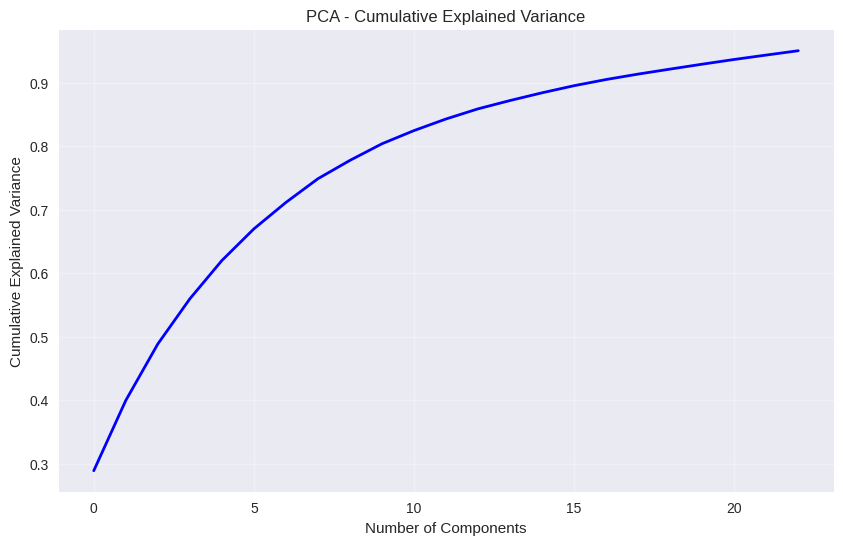

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'b-', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True, alpha=0.3)
plt.show()

### **Model dengan Semua Metode Split**

In [15]:
models = {
    "SVM": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=42, n_jobs=-1, max_iter=1000)
}

In [16]:
splits = [(0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]
results = {}

for train_size, test_size in splits:
    print(f"\n{'='*50}")
    print(f"SPLIT {int(train_size*100)}:{int(test_size*100)}")
    print(f"{'='*50}")

    # split data
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_pca, y_train,
        train_size=train_size,
        stratify=y_train,
        random_state=42
    )

    results_split = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        start_time = time.time()

        # training
        model.fit(X_tr, y_tr)

        # prediction
        y_pred = model.predict(X_te)
        training_time = time.time() - start_time

        # metrics
        accuracy = accuracy_score(y_te, y_pred)
        precision = precision_score(y_te, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_te, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_te, y_pred, average='weighted', zero_division=0)

        results_split[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'training_time': training_time
        }

        print(f"{name}:")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")
        print(f"Time:      {training_time:.2f}s")

    results[f"{int(train_size*100)}:{int(test_size*100)}"] = results_split


SPLIT 70:30

Training SVM...
SVM:
Accuracy:  0.8978
Precision: 0.8986
Recall:    0.8978
F1-Score:  0.8978
Time:      4.73s

Training Random Forest...
Random Forest:
Accuracy:  0.8698
Precision: 0.8699
Recall:    0.8698
F1-Score:  0.8694
Time:      6.59s

Training KNN...
KNN:
Accuracy:  0.8958
Precision: 0.8966
Recall:    0.8958
F1-Score:  0.8954
Time:      0.50s

Training Logistic Regression...
Logistic Regression:
Accuracy:  0.6484
Precision: 0.6456
Recall:    0.6484
F1-Score:  0.6458
Time:      2.42s

SPLIT 80:20

Training SVM...
SVM:
Accuracy:  0.9023
Precision: 0.9032
Recall:    0.9023
F1-Score:  0.9024
Time:      4.60s

Training Random Forest...
Random Forest:
Accuracy:  0.8840
Precision: 0.8848
Recall:    0.8840
F1-Score:  0.8839
Time:      7.83s

Training KNN...
KNN:
Accuracy:  0.9073
Precision: 0.9083
Recall:    0.9073
F1-Score:  0.9071
Time:      0.21s

Training Logistic Regression...
Logistic Regression:
Accuracy:  0.6463
Precision: 0.6430
Recall:    0.6463
F1-Score:  0.6431

**Cross-Validation dengan k=5**

In [17]:
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nCross-validation untuk {name}...")

    # CV untuk multiple metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }

    cv_scores = cross_val_score(model, X_pca, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

    cv_results[name] = {
        'mean_accuracy': np.mean(cv_scores),
        'std_accuracy': np.std(cv_scores),
        'all_scores': cv_scores
    }

    print(f"   {name} - CV Accuracy: {cv_results[name]['mean_accuracy']:.4f} (±{cv_results[name]['std_accuracy']:.4f})")
    print(f"   Semua scores: {[f'{score:.4f}' for score in cv_scores]}")


Cross-validation untuk SVM...
   SVM - CV Accuracy: 0.8977 (±0.0060)
   Semua scores: ['0.8973', '0.8903', '0.8963', '0.8957', '0.9087']

Cross-validation untuk Random Forest...
   Random Forest - CV Accuracy: 0.8671 (±0.0056)
   Semua scores: ['0.8703', '0.8667', '0.8653', '0.8580', '0.8750']

Cross-validation untuk KNN...
   KNN - CV Accuracy: 0.9018 (±0.0043)
   Semua scores: ['0.9063', '0.8970', '0.8990', '0.8990', '0.9077']

Cross-validation untuk Logistic Regression...
   Logistic Regression - CV Accuracy: 0.6414 (±0.0088)
   Semua scores: ['0.6517', '0.6377', '0.6353', '0.6303', '0.6520']


### **Perbandingan Semua Metode**

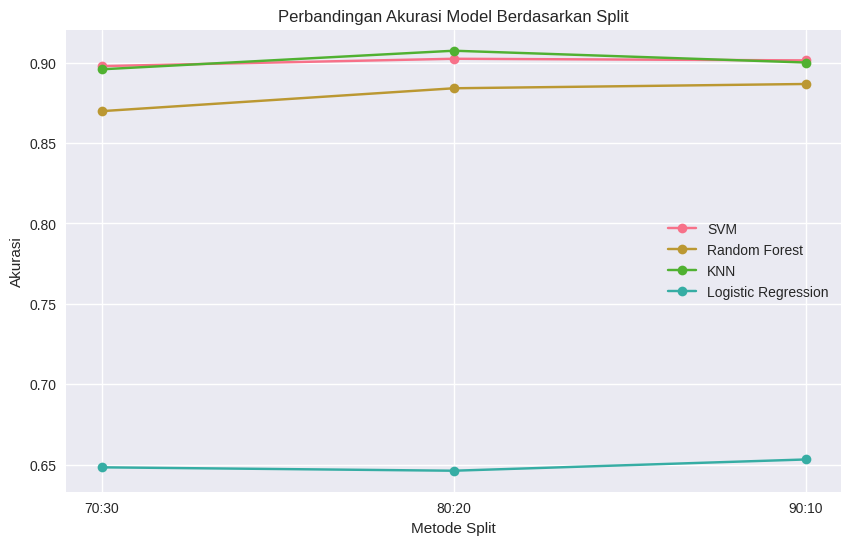

In [18]:
plt.figure(figsize=(10,6))
for name in models.keys():
    accs = [results[split][name]['accuracy'] for split in results.keys()]
    plt.plot(['70:30','80:20','90:10'], accs, marker='o', label=name)
plt.title("Perbandingan Akurasi Model Berdasarkan Split")
plt.xlabel("Metode Split")
plt.ylabel("Akurasi")
plt.legend()
plt.grid(True)
plt.show()


### **Hyperparameter Tuning untuk Model Terbaik**

In [19]:
X_tr, X_te, y_tr, y_te = train_test_split(X_pca, y_train, train_size=0.8, stratify=y_train, random_state=42)

In [20]:
# tuning untuk Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_tr, y_tr)
print("Random Forest - Best params:", rf_grid.best_params_)
print("Random Forest - Best score:", rf_grid.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Random Forest - Best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - Best score: 0.8521666666666666


In [21]:
# tuning untuk SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf', 'li near']
}

svm_grid = GridSearchCV(
    SVC(random_state=42),
    svm_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
svm_grid.fit(X_tr, y_tr)
print("SVM - Best params:", svm_grid.best_params_)
print("SVM - Best score:", svm_grid.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
SVM - Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVM - Best score: 0.9259999999999998


In [22]:
# tuning untuk KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    knn_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
knn_grid.fit(X_tr, y_tr)
print("KNN - Best params:", knn_grid.best_params_)
print("KNN - Best score:", knn_grid.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
KNN - Best params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
KNN - Best score: 0.89


In [23]:
logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

In [24]:
# tuning untuk Logistic Regression
logreg_grid = GridSearchCV(
    LogisticRegression(random_state=42, n_jobs=-1, solver='liblinear'),
    logreg_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
logreg_grid.fit(X_tr, y_tr)
print("Logistic Regression - Best params:", logreg_grid.best_params_)
print("Logistic Regression - Best score:", logreg_grid.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Logistic Regression - Best params: {'C': 10, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}
Logistic Regression - Best score: 0.6370833333333333


In [25]:
# bandingkan ketiga model dan pilih yang terbaik
model_scores = {
    'Random Forest': rf_grid.best_score_,
    'SVM': svm_grid.best_score_,
    'KNN': knn_grid.best_score_,
    'Logistic Regression': logreg_grid.best_score_
}

best_model_name = max(model_scores, key=model_scores.get)
best_score = model_scores[best_model_name]

# assign model terbaik
if best_model_name == 'Random Forest':
    best_model = rf_grid.best_estimator_
elif best_model_name == 'SVM':
    best_model = svm_grid.best_estimator_
else:
    best_model = knn_grid.best_estimator_

print(f"\nPerbandingan Model:")
for model, score in model_scores.items():
    print(f"   {model}: {score:.4f}")
print(f"Model Terbaik: {best_model_name} (Score: {best_score:.4f})")


Perbandingan Model:
   Random Forest: 0.8522
   SVM: 0.9260
   KNN: 0.8900
   Logistic Regression: 0.6371
Model Terbaik: SVM (Score: 0.9260)


### **EVALUASI MODEL**

In [26]:
best_model.fit(X_tr, y_tr)
y_pred_best = best_model.predict(X_te)

print(f"\nEVALUASI MODEL TERBAIK ({best_model_name}):")
print(f"Accuracy:  {accuracy_score(y_te, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_te, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_te, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_te, y_pred_best, average='weighted', zero_division=0):.4f}")


EVALUASI MODEL TERBAIK (SVM):
Accuracy:  0.9363
Precision: 0.9370
Recall:    0.9363
F1-Score:  0.9365


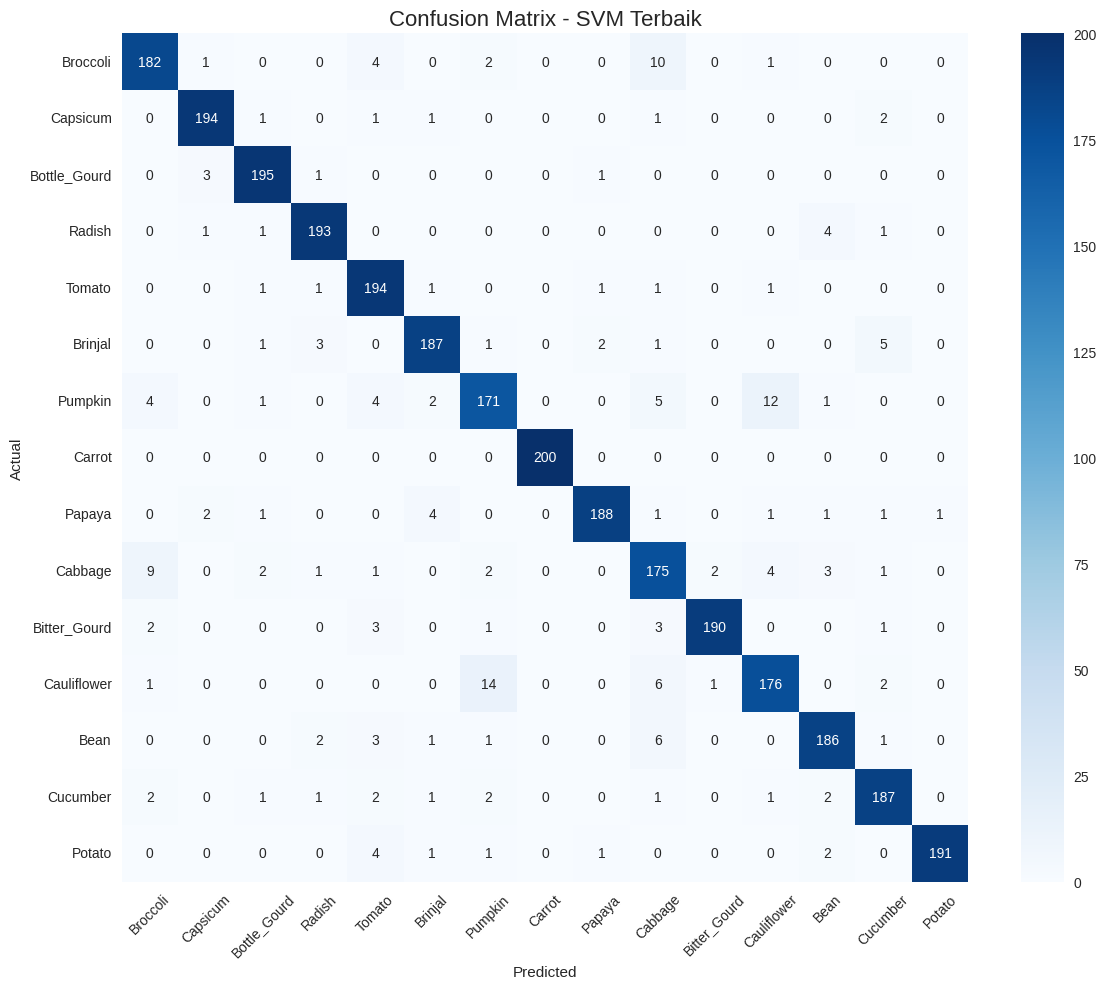

In [27]:
# confusion matrix
cm = confusion_matrix(y_te, y_pred_best)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name} Terbaik', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [28]:
print("\nCLASSIFICATION REPORT:")
print(classification_report(y_te, y_pred_best, target_names=class_names, zero_division=0))


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Broccoli       0.91      0.91      0.91       200
    Capsicum       0.97      0.97      0.97       200
Bottle_Gourd       0.96      0.97      0.97       200
      Radish       0.96      0.96      0.96       200
      Tomato       0.90      0.97      0.93       200
     Brinjal       0.94      0.94      0.94       200
     Pumpkin       0.88      0.85      0.87       200
      Carrot       1.00      1.00      1.00       200
      Papaya       0.97      0.94      0.96       200
     Cabbage       0.83      0.88      0.85       200
Bitter_Gourd       0.98      0.95      0.97       200
 Cauliflower       0.90      0.88      0.89       200
        Bean       0.93      0.93      0.93       200
    Cucumber       0.93      0.94      0.93       200
      Potato       0.99      0.95      0.97       200

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
we

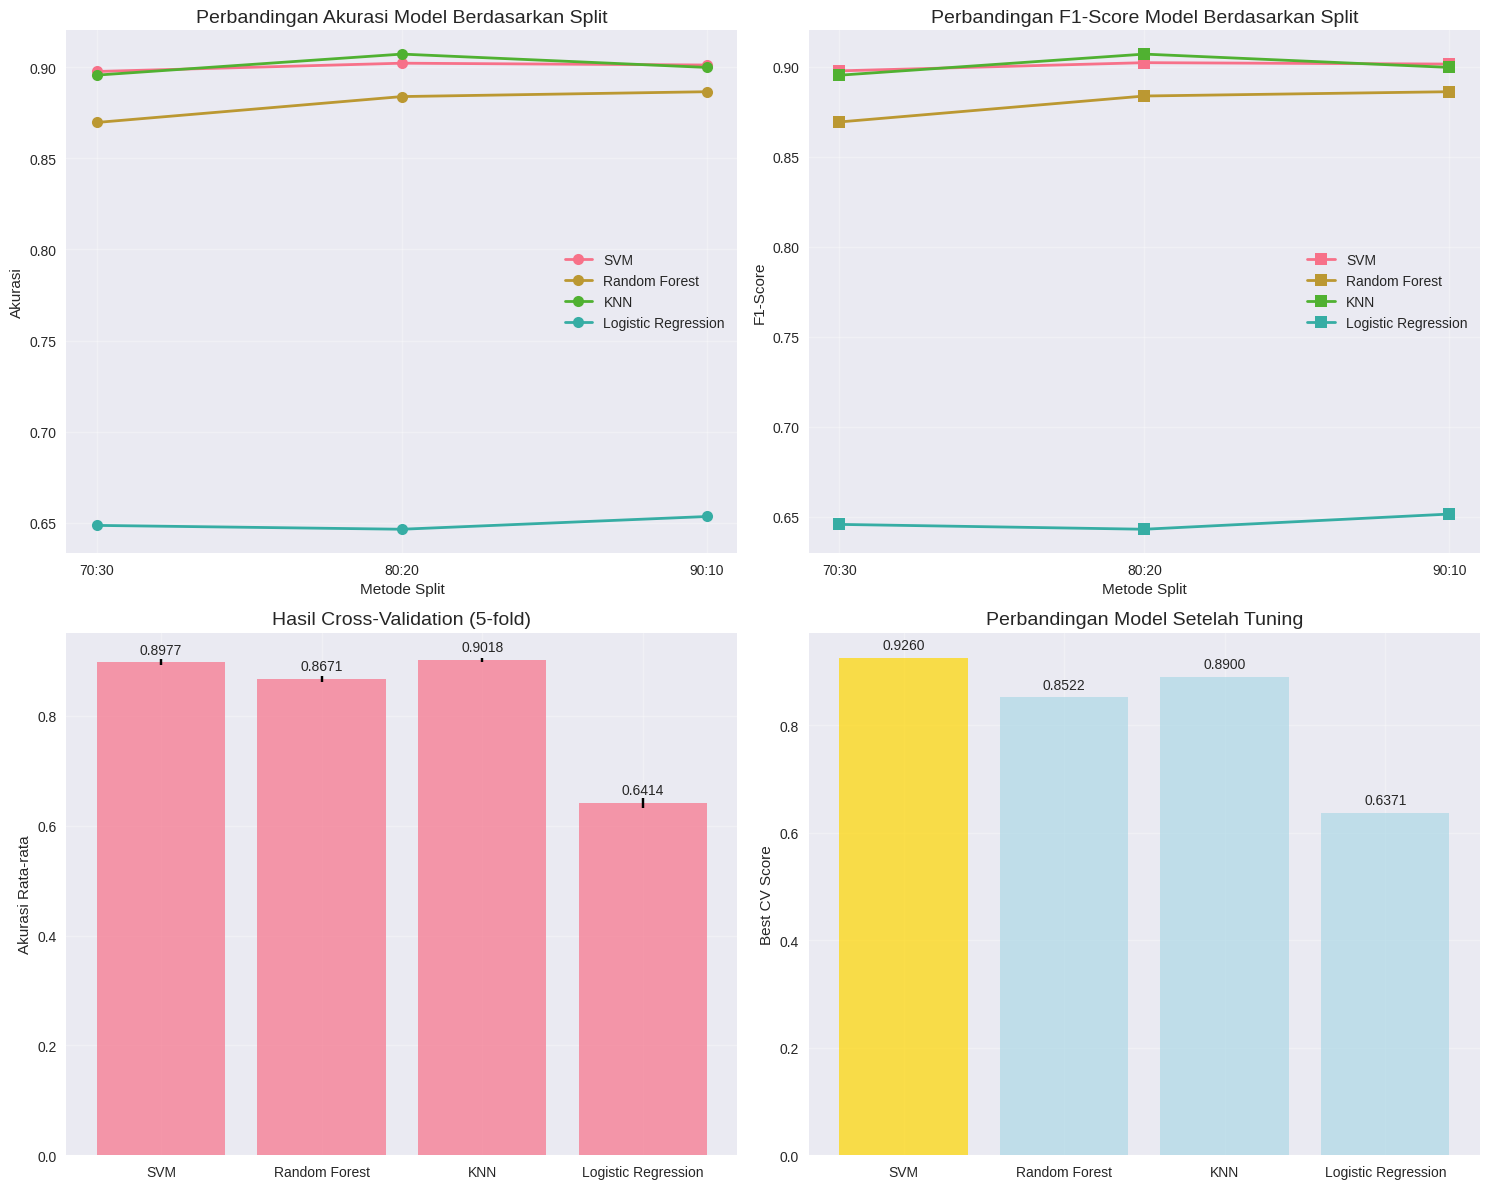

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

split_names = list(results.keys())
model_names = list(models.keys())

# akurasi per split
for model_name in model_names:
    accuracies = [results[split][model_name]['accuracy'] for split in split_names]
    axes[0,0].plot(split_names, accuracies, 'o-', linewidth=2, markersize=8, label=model_name)

axes[0,0].set_title('Perbandingan Akurasi Model Berdasarkan Split', fontsize=14)
axes[0,0].set_xlabel('Metode Split')
axes[0,0].set_ylabel('Akurasi')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# F1-Score per split
for model_name in model_names:
    f1_scores = [results[split][model_name]['f1_score'] for split in split_names]
    axes[0,1].plot(split_names, f1_scores, 's-', linewidth=2, markersize=8, label=model_name)

axes[0,1].set_title('Perbandingan F1-Score Model Berdasarkan Split', fontsize=14)
axes[0,1].set_xlabel('Metode Split')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# cross-validation results
cv_means = [cv_results[name]['mean_accuracy'] for name in model_names]
cv_stds = [cv_results[name]['std_accuracy'] for name in model_names]

bars = axes[1,0].bar(model_names, cv_means, yerr=cv_stds, capsize=5, alpha=0.7)
axes[1,0].set_title('Hasil Cross-Validation (5-fold)', fontsize=14)
axes[1,0].set_ylabel('Akurasi Rata-rata')
axes[1,0].grid(True, alpha=0.3)

for bar, mean in zip(bars, cv_means):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{mean:.4f}', ha='center', va='bottom')

# perbandingan model terbaik
best_scores = [model_scores[name] for name in model_names]
colors = ['lightblue' if name != best_model_name else 'gold' for name in model_names]

bars = axes[1,1].bar(model_names, best_scores, color=colors, alpha=0.7)
axes[1,1].set_title('Perbandingan Model Setelah Tuning', fontsize=14)
axes[1,1].set_ylabel('Best CV Score')
axes[1,1].grid(True, alpha=0.3)

for bar, score in zip(bars, best_scores):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [30]:
summary_data = []
for split_name, split_results in results.items():
    for model_name, metrics in split_results.items():
        summary_data.append({
            'Split': split_name,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1_score'],
            'Time(s)': metrics['training_time']
        })

summary_df = pd.DataFrame(summary_data)
print("\nPerforma Model berdasarkan Split:")
print(summary_df.round(4))

print("\nCross-Validation Results:")
cv_summary = pd.DataFrame({
    'Mean Accuracy': [cv_results[name]['mean_accuracy'] for name in model_names],
    'Std Accuracy': [cv_results[name]['std_accuracy'] for name in model_names]
}, index=model_names)
print(cv_summary.round(4))

print(f"\nModel Terbaik: {best_model_name}")
print(f"Best CV Score: {best_score:.4f}")


Performa Model berdasarkan Split:
    Split                Model  Accuracy  Precision  Recall  F1-Score  Time(s)
0   70:30                  SVM    0.8978     0.8986  0.8978    0.8978   4.7348
1   70:30        Random Forest    0.8698     0.8699  0.8698    0.8694   6.5905
2   70:30                  KNN    0.8958     0.8966  0.8958    0.8954   0.5000
3   70:30  Logistic Regression    0.6484     0.6456  0.6484    0.6458   2.4178
4   80:20                  SVM    0.9023     0.9032  0.9023    0.9024   4.5974
5   80:20        Random Forest    0.8840     0.8848  0.8840    0.8839   7.8310
6   80:20                  KNN    0.9073     0.9083  0.9073    0.9071   0.2141
7   80:20  Logistic Regression    0.6463     0.6430  0.6463    0.6431   1.8365
8   90:10                  SVM    0.9013     0.9033  0.9013    0.9016   4.4075
9   90:10        Random Forest    0.8867     0.8870  0.8867    0.8862   9.0130
10  90:10                  KNN    0.9000     0.9004  0.9000    0.8997   0.1149
11  90:10  Logist

### **Simpan Model Terbaik**

In [31]:
joblib.dump(best_model, 'best_vegetable_classifier.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')
print("Model, scaler, dan PCA telah disimpan.")

Model, scaler, dan PCA telah disimpan.
